In [ ]:
!nvidia-smi

Tue May  3 23:48:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    49W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from matplotlib import pyplot as plt
from glob import glob
from time import time
import tensorflow as tf
import pathlib
import os

In [ ]:
!cp -r 'drive/MyDrive/Dataset/image_super_resolution_v2' .

In [ ]:
videos = glob('image_super_resolution_v2/videos/*.mp4')

if not pathlib.Path('image_super_resolution_v2/images/train').exists():
    os.mkdir('image_super_resolution_v2/images/train')

for video in videos:
    filename = pathlib.Path(video).stem

    print(f'Processing {filename}')
    os.system(f'ffmpeg -y -i "{video}" -r 1 "image_super_resolution_v2/images/train/{filename}_%4d.bmp"')

Processing national_geographic-tigers_101
Processing yuni_vebra-lewat_angin_wengi
Processing yuni_vebra-rembulan
Processing misel-akhir_tak_bahagia


In [ ]:
files = glob('image_super_resolution_v2/images/train/*.bmp')


def load_image(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_image(x, channels=3, expand_animations=False)
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.image.resize(x, (1080 // 4, 1920 // 4), method='bicubic', antialias=True)
    return x

gausial_noise = tf.keras.layers.GaussianNoise(1/32.)

def create_pair(y):
    x = tf.image.random_jpeg_quality(y, 20, 60)
    x = gausial_noise(x, training=True)
    return x, y


def get_random_patch_coordinate(x, y, size):
    x = tf.random.uniform([], 0, x - size, dtype=tf.int32)
    y = tf.random.uniform([], 0, y - size, dtype=tf.int32)
    return x, y


def get_random_patches(x, y, size=128, count=8):
    h, w = tf.shape(x)[0], tf.shape(x)[1]

    patches_x = []
    patches_y = []

    for _ in range(count):
        random_x, random_y = get_random_patch_coordinate(h, w, size)

        patch_x = tf.image.crop_to_bounding_box(x, random_x, random_y, size, size)
        patch_y = tf.image.crop_to_bounding_box(y, random_x, random_y, size, size)

        patches_x.append(patch_x)
        patches_y.append(patch_y)

    patches_x = tf.convert_to_tensor(patches_x)
    patches_y = tf.convert_to_tensor(patches_y)

    return patches_x, patches_y


def quantize(x):
    x = tf.clip_by_value(x, .0, 1.)
    x = tf.round(x * 255)
    return x

In [ ]:
dataset = tf.data.Dataset.list_files(files).shuffle(len(files)).map(load_image)
dataset = dataset.map(create_pair).map(get_random_patches).unbatch().map(lambda x, y: (quantize(x), quantize(y))).shuffle(1024)

n_train = int((len(files) * 8) * 0.9)
print(f'Training on {n_train} images')

train_ds = dataset.take(n_train).cache().shuffle(1024 * 4, reshuffle_each_iteration=True)
val_ds = dataset.skip(n_train).cache()

Training on 8179 images


In [ ]:
sample = train_ds.batch(8).as_numpy_iterator().next()

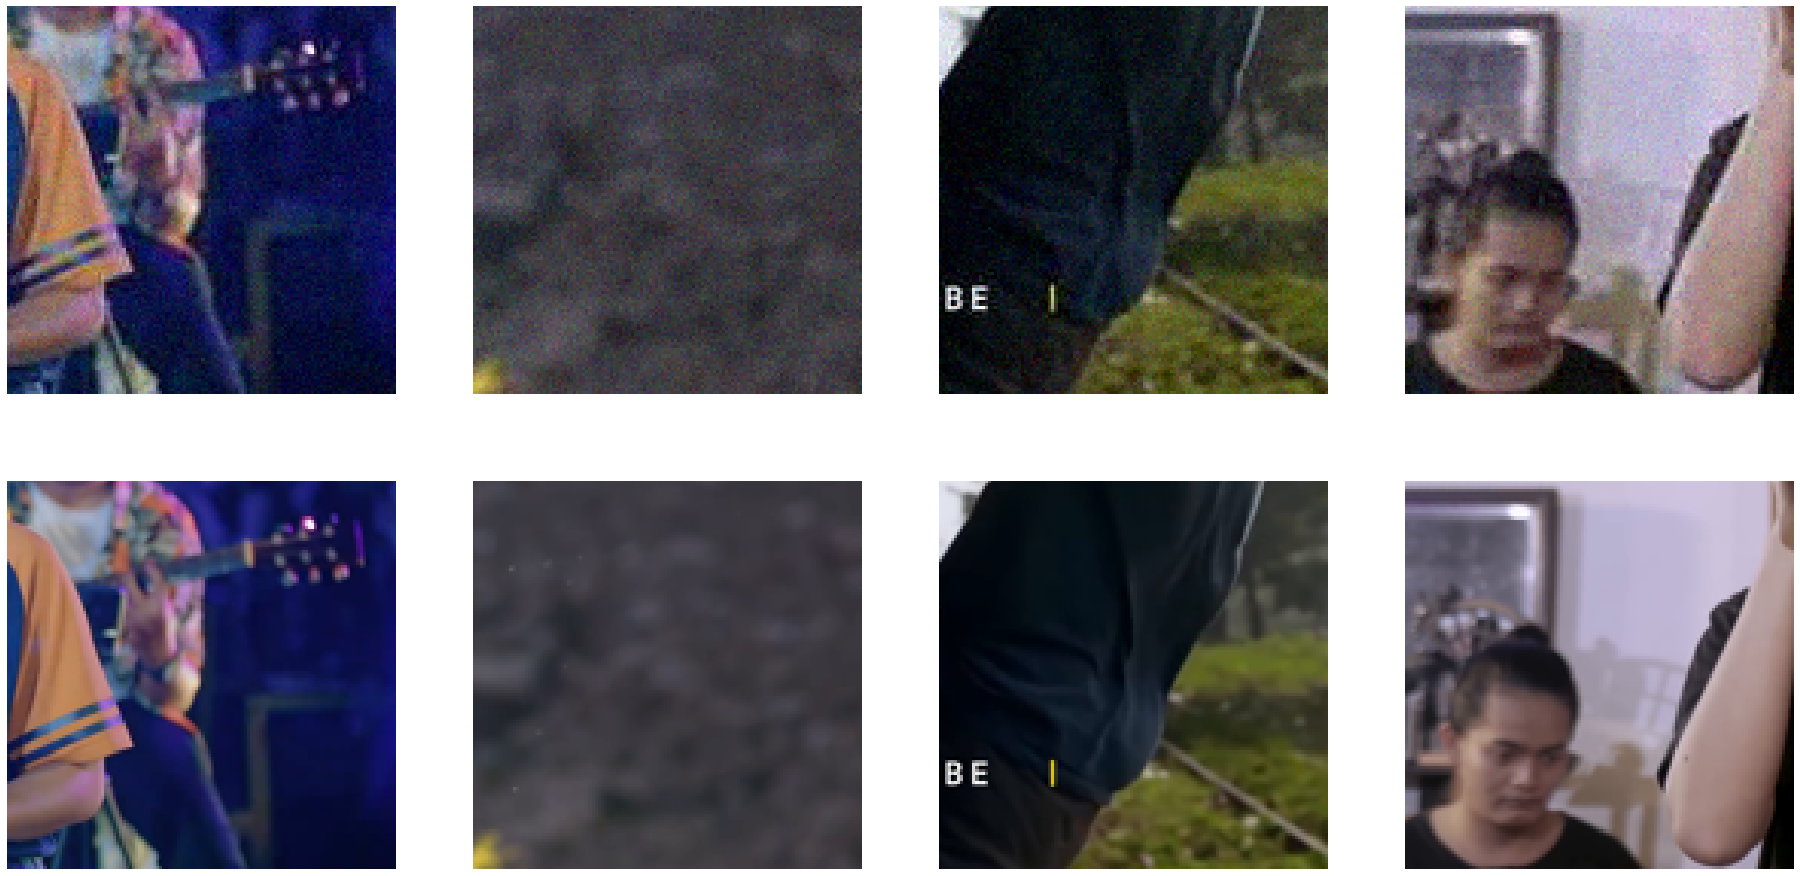

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(8 * 4, 8 * 2))

for i_y, ax_y in enumerate(ax):
    for i_x, _ax in enumerate(ax_y):
        _ax.imshow(sample[i_y][i_x] / 255)
        _ax.axis('off')

In [ ]:
start = _start = time()
for _ in train_ds.batch(128):
    print(f'{time() - _start:.2f}s', end='\r')
    _start = time()
print(f'{time() - start:.2f}s')

start = _start = time()
for _ in val_ds.batch(128):
    print(f'{time() - _start:.2f}s', end='\r')
    _start = time()
print(f'{time() - start:.2f}s')

34.68s
32.40s


In [ ]:
def down_block(x, filter):
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x)
    x = skip = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x)
    x = x + skip
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    return x

def up_block(x, filter, skip=None):
    x = _skip = tf.keras.layers.Conv2DTranspose(filter, (3, 3), padding='same', strides=(2, 2))(x)
    if skip is not None:
        x = tf.keras.layers.Concatenate()([x, skip])
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(filter, (3, 3), padding='same')(x)
    x = x + _skip
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    return x

def get_model():
    _input = x = tf.keras.layers.Input(shape=(None, None, 3))
    x = skip = tf.keras.layers.Rescaling(1 / 255.)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = _skip = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = x + _skip
    x = d_0 = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)


    x = d_1 = down_block(x,  64) #64
    x = d_2 = down_block(x, 128) #32
    x = d_3 = down_block(x, 256) #16
    x = d_4 = down_block(x, 512) #8
    
    x = down_block(x, 512) # 4

    x = up_block(x, 512, d_4) #8
    x = up_block(x, 256, d_3) #16
    x = up_block(x, 128, d_2) #32
    x = up_block(x,  64, d_1) #64
    x = up_block(x,  32, d_0) #128

    x = tf.keras.layers.Conv2D(3, (1, 1), padding='same')(x)
    x = x + skip
    x = tf.keras.layers.Rescaling(255)(x)
    return tf.keras.Model(_input, x)


vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(None, None, 3))
vgg = tf.keras.models.Model(vgg.inputs, vgg.get_layer('block3_conv3').output)
vgg.trainable = False

@tf.function
def vgg_loss(y_true, y_pred):
    y_true, y_pred = tf.keras.applications.vgg16.preprocess_input(y_true), tf.keras.applications.vgg16.preprocess_input(y_pred)

    perceptual_a = vgg(y_true)
    perceptual_b = vgg(y_pred)

    loss = tf.keras.losses.mse(perceptual_a, perceptual_b)
    return tf.reduce_mean(loss)


@tf.function
def composite_loss(y_true, y_pred):
    return tf.keras.losses.mse(y_true, y_pred) + (vgg_loss(y_true, y_pred) * 1e-4)


BATCH_SIZE = 32

generator = get_model()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=n_train // BATCH_SIZE, decay_rate=.96)
generator.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=composite_loss, metrics=['mae', 'mse', vgg_loss])

generator.fit(train_ds.batch(BATCH_SIZE).prefetch(32), validation_data=val_ds.batch(BATCH_SIZE).prefetch(32), epochs=8)
generator.save_weights('models/generator.tf')

Epoch 1/32
256/256 [==============================] - 68s 246ms/step - loss: 156.3238 - mae: 7.3749 - mse: 151.2244 - vgg_loss: 50985.1367 - val_loss: 69.1198 - val_mae: 5.4914 - val_mse: 65.2039 - val_vgg_loss: 39193.1680
Epoch 2/32
256/256 [==============================] - 62s 243ms/step - loss: 61.4342 - mae: 5.0735 - mse: 57.8562 - vgg_loss: 35775.8125 - val_loss: 61.0127 - val_mae: 4.9746 - val_mse: 57.5280 - val_vgg_loss: 34899.7344
Epoch 3/32
256/256 [==============================] - 62s 242ms/step - loss: 56.2661 - mae: 4.7857 - mse: 53.0146 - vgg_loss: 32515.4590 - val_loss: 57.2046 - val_mae: 4.8022 - val_mse: 53.9242 - val_vgg_loss: 32863.0742
Epoch 4/32
256/256 [==============================] - 62s 243ms/step - loss: 53.3519 - mae: 4.6401 - mse: 50.2802 - vgg_loss: 30714.9668 - val_loss: 54.5248 - val_mae: 4.6455 - val_mse: 51.4205 - val_vgg_loss: 31105.8555
Epoch 5/32
256/256 [==============================] - 62s 242ms/step - loss: 51.1834 - mae: 4.5210 - mse: 48.2619 

KeyboardInterrupt: ignored

In [ ]:
generator.compile(optimizer='adam')
generator.save('drive/MyDrive/Project/Image_Denoise/U-Net/generator.tf', include_optimizer=False)

INFO:tensorflow:Assets written to: drive/MyDrive/Project/Image_Denoise/U-Net/generator.tf/assets


In [ ]:
sample_x, sample_y = val_ds.skip(32).as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


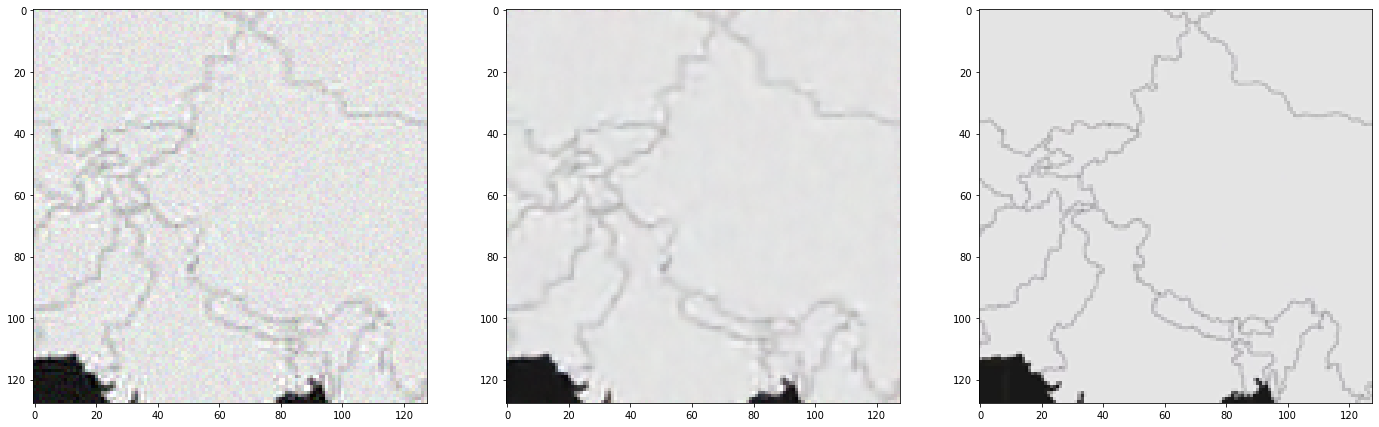

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 8))

ax[0].imshow(sample_x / 255)
ax[1].imshow(generator(sample_x[None, :, :, :])[0] / 255)
ax[2].imshow(sample_y / 255)

In [ ]:
disc_real = []
disc_fake = []
disc_x = []

for x, y in train_ds.batch(64):
    n_set = y.shape[0]
    disc_x.extend(x)
    disc_real.extend(y)
    disc_fake.extend(generator(x))

disc_real = tf.convert_to_tensor(disc_real)
disc_fake = tf.convert_to_tensor(disc_fake)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


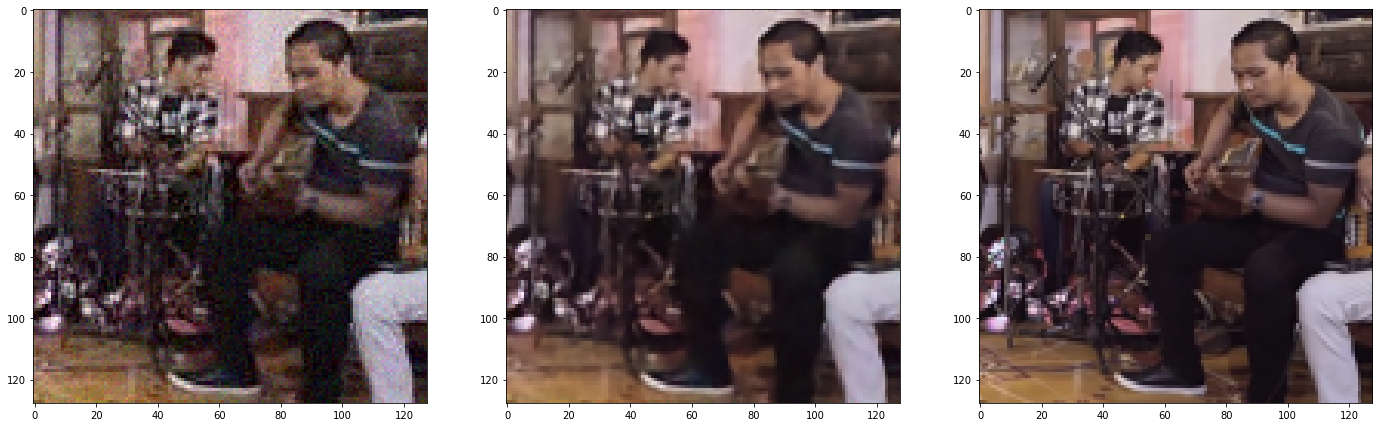

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 8))

index = 4

ax[0].imshow(disc_x[index] / 255)
ax[1].imshow(disc_fake[index] / 255)
ax[2].imshow(disc_real[index] / 255)

In [ ]:
import numpy as np

ds_x = [*disc_real, *disc_fake]
ds_y = [*[1] * len(disc_real), *[0] * len(disc_fake)]

ds_x = np.asarray(ds_x, dtype=np.uint8)
ds_y = np.asarray(ds_y, dtype=np.uint8)

index = np.arange(len(ds_x))
np.random.shuffle(index)

ds_x = ds_x[index]
ds_y = ds_y[index]

In [ ]:
disc_train_ds = tf.data.Dataset.from_tensor_slices((ds_x, ds_y))
disc_val_ds = disc_train_ds.skip(int(len(ds_x) * .8))
disc_train_ds = disc_train_ds.take(int(len(ds_x) * .8))

In [ ]:
def get_discriminator():
    x = _input = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Rescaling(255)(x)

    for i in range(5):
        x = tf.keras.layers.Conv2D(32 * (i + 1), (3, 3), padding='same', activation='leaky_relu')(x)
        x = tf.keras.layers.Conv2D(32 * (i + 1), (3, 3), padding='same', activation='leaky_relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(.33)(x)
    x = tf.keras.layers.Dense(1)(x)

    return tf.keras.models.Model(_input, x)

discriminator = get_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['acc'])

discriminator.fit(disc_train_ds.batch(32), validation_data=disc_val_ds.batch(32), epochs=8)
discriminator.save('models/discriminator.tf')

Epoch 1/8
409/409 [==============================] - 14s 31ms/step - loss: 0.6136 - acc: 0.6082 - val_loss: 0.5418 - val_acc: 0.5902
Epoch 2/8
409/409 [==============================] - 12s 29ms/step - loss: 0.4491 - acc: 0.7175 - val_loss: 0.4220 - val_acc: 0.7934
Epoch 3/8
409/409 [==============================] - 12s 30ms/step - loss: 0.4331 - acc: 0.7297 - val_loss: 0.3522 - val_acc: 0.7680
Epoch 4/8
409/409 [==============================] - 12s 29ms/step - loss: 0.3472 - acc: 0.8067 - val_loss: 0.3414 - val_acc: 0.7732
Epoch 5/8
409/409 [==============================] - 12s 29ms/step - loss: 0.2721 - acc: 0.8639 - val_loss: 0.1850 - val_acc: 0.9425
Epoch 6/8
409/409 [==============================] - 12s 29ms/step - loss: 0.2382 - acc: 0.8874 - val_loss: 0.2635 - val_acc: 0.8909
Epoch 7/8
409/409 [==============================] - 12s 29ms/step - loss: 0.1973 - acc: 0.9153 - val_loss: 0.1418 - val_acc: 0.9532
Epoch 8/8
409/409 [==============================] - 12s 29ms/step - 

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.function
def train_step(x, y):
    x, y = tf.cast(x, dtype=tf.float32), tf.cast(y, dtype=tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(x, training=True)

        real_output = discriminator(y, training=True)
        fake_output = discriminator(generated_images, training=True)

        _mse = tf.keras.losses.mean_squared_error(y, generated_images)
        _perceptual = tf.reduce_mean(vgg_loss(y, generated_images)) * 1e-4
        _gen = generator_loss(fake_output) * 1e-2

        gen_loss = _mse + _perceptual +_gen
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    history = {}
    history['gen_loss'] = tf.reduce_mean(gen_loss)
    history['gen_pnsr'] = tf.reduce_mean(tf.image.psnr(y, generated_images, 255.))
    history['gen_mse'] = tf.reduce_mean(_mse)
    history['gen_mae'] = tf.reduce_mean(tf.keras.losses.mean_absolute_error(y, generated_images))
    history['gen_perceptual'] = tf.reduce_mean(_perceptual)
    history['gen_disc'] = tf.reduce_mean(_gen)
    history['disc_loss'] = tf.reduce_mean(disc_loss)
    return history

generator.load_weights('models/generator.tf')
discriminator.load_weights('models/discriminator.tf')

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(32):
    print ('\nEpoch : {}'.format(epoch + 1))

    for i, image_batch in enumerate(train_ds.batch(16).take(512)):
        history = train_step(*image_batch)
        print(f"\r\t{i + 1:3d} - Generator Loss : {history['gen_loss']:.4f} - MSE : {history['gen_mse']:.4f}  - MAE : {history['gen_mae']:.4f} - Disc : {history['gen_disc']:.4f} - Perceptual : {history['gen_perceptual']:.4f}, PNSR : {history['gen_pnsr']:.3f}, Discriminator Loss : {history['disc_loss']:.4f}", end="")
    
    generator.evaluate(val_ds.batch(64))


Epoch : 1
15/15 [==============================] - 4s 221ms/step - loss: 45.3094 - mae: 4.1439 - mse: 42.8542 - vgg_loss: 24711.8301

Epoch : 2
15/15 [==============================] - 4s 221ms/step - loss: 45.1290 - mae: 4.1481 - mse: 42.7008 - vgg_loss: 24446.7227

Epoch : 3
15/15 [==============================] - 4s 221ms/step - loss: 44.5988 - mae: 4.1007 - mse: 42.1913 - vgg_loss: 24232.4609

Epoch : 4
15/15 [==============================] - 4s 221ms/step - loss: 44.6500 - mae: 4.1104 - mse: 42.2528 - vgg_loss: 24132.1328

Epoch : 5
15/15 [==============================] - 4s 221ms/step - loss: 44.1836 - mae: 4.0717 - mse: 41.8093 - vgg_loss: 23903.4277

Epoch : 6
15/15 [==============================] - 4s 221ms/step - loss: 44.0361 - mae: 4.0611 - mse: 41.6784 - vgg_loss: 23740.0762

Epoch : 7
15/15 [==============================] - 4s 221ms/step - loss: 43.9437 - mae: 4.0571 - mse: 41.6080 - vgg_loss: 23519.7617

Epoch : 8
15/15 [==============================] - 4s 221ms/s

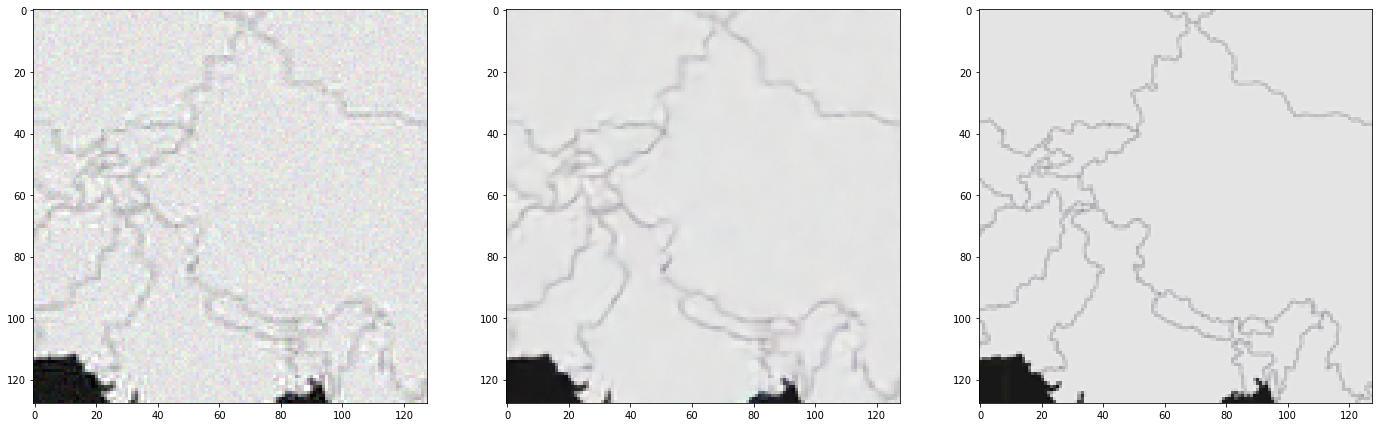

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 8))

ax[0].imshow(sample_x / 255)
ax[1].imshow(generator(sample_x[None, :, :, :])[0] / 255)
ax[2].imshow(sample_y / 255)